Video Notes:
- end on a note of the webapp
- say i'm going to move to webapp at the end
- ask an audience member for locations
- say 'pooled' ride instead of shared
- double check spelling
- shorter problem slide? could make it more personal. 
- Some visual of a person going from the airport?


This notebook is intended to simulate what the UI will look like and is top-level

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns
from scipy.stats import gaussian_kde
import datetime
import pytz
import altair as alt
sns.set()
import matplotlib
matplotlib.rcParams['figure.dpi'] = 144

from datetime import datetime, timedelta

from Fair_Fare.feature_utils import load_hdf
from Fair_Fare.aggregations import bin_on_time_distance
from Fair_Fare.model_utils import get_model_from_file, predict_fare
from Fair_Fare.trips import Stop, Ride
from Fair_Fare.api_interactions import price_estimate_from_lyft


%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:

def get_time_in_chicago():
    utc_now = pytz.utc.localize(datetime.utcnow())
    return utc_now.astimezone(pytz.timezone("America/Chicago"))

In [3]:
models = {"path":"models/", "taxi":"taxi_xgb_full_reduced_params", "rideshare":"tnp_xgb_full_reduced_params" }
data = {"path":"data/","taxi":"taxi_test.h5", "rideshare":"tnp_test.h5" }

taxi_model = get_model_from_file(models['path']+models['taxi'])
taxi_data = load_hdf(data['path']+data['taxi'])

rideshare_model = get_model_from_file(models['path']+models['rideshare'])
rideshare_data = load_hdf(data['path']+data['rideshare'])



In [84]:
def text_to_fares(binned_rs,binned_tax, start, end, forecast_hours = 5):
    curr_time = get_time_in_chicago()
    model_estimate = {'rideshare_model_estimate':[],'rideshare_shared_model_estimate':[],'taxi_estimate':[]}
    
    # forecast for next few hours
    times = [curr_time+timedelta(hours=i) for i in range(forecast_hours)] 
    rides = [Ride(start,end, time, bRideshare = True, bShared = False) for time in times]
        
    for ride in rides:
        model_estimate['rideshare_model_estimate'].append(predict_fare(ride, rideshare_model)[0])
        ride.bShared = True
        ride.build_row()
        model_estimate['rideshare_shared_model_estimate'].append(predict_fare(ride, rideshare_model)[0])
    for ride in rides:
        ride.bRideshare = False
        ride.build_row()
        model_estimate['taxi_estimate'].append(predict_fare(ride, taxi_model)[0])

    # only one lyft estimate is available
    lyft_estimates = price_estimate_from_lyft(ride.start.tuple,ride.end.tuple)
    
    td_tup = (ride.traveltime,ride.miles)
    
    binned_pth_tax = binned_tax.time_distance_to_bin(td_tup)
    group_tax =  binned_tax.df[binned_tax.df.td_bin == binned_pth_tax]
    
    binned_pth_rs = binned_rs.time_distance_to_bin(td_tup)
    group_rs =  binned_rs.df[binned_rs.df.td_bin == binned_pth_rs]
    return model_estimate, lyft_estimates, group_tax, group_rs


def run_Fair_Fare(USER_PARAMS):
    rideshare_binned = bin_on_time_distance(rideshare_data)
    ## TODO: Investigate the binning on the taxi data (time is very discrete)
    taxi_binned = bin_on_time_distance(taxi_data)

    rideshare_model_pred, lyft_estimate,taxi_group, rideshare_group= text_to_fares(rideshare_binned,taxi_binned,USER_PARAMS['pickup'], USER_PARAMS['dropoff'], USER_PARAMS['forecast_hrs'])

    rideshare_shared_fares = rideshare_group[rideshare_group["Shared_Trip_Authorized"] == True].Final_Fare
    rideshare_fares = rideshare_group[rideshare_group["Shared_Trip_Authorized"] == False].Final_Fare
    taxi_fares = taxi_group.Final_Fare

    to_df = {'Rideshare_regular_price_estimate': rideshare_model_pred['rideshare_model_estimate'], 'Rideshare_shared_price_estimate': rideshare_model_pred['rideshare_shared_model_estimate'],
     'Taxi_price_estimate' :rideshare_model_pred['taxi_estimate']}
    return rideshare_model_pred, lyft_estimate, rideshare_shared_fares,rideshare_fares,taxi_fares,to_df

def kde(data, nbins = 200):
    data = data[~np.isnan(data)]
    gkde = gaussian_kde(data,bw_method = .5)
    grid = np.linspace(-10,150,nbins)
    kde_vals = gkde.evaluate(grid)
    lo, hi= np.min(data), np.max(data)
    loidx = np.argmin(abs(lo-grid))
    hiidx = np.argmin(abs(hi-grid))
    return {'x':grid, 'y':kde_vals,'valid_range':(loidx,hiidx)}


## todo build out a wide dataframe only in the valid_range
def build_df_for_altair(fare_dict):
    df = pd.DataFrame()
    for name, fares in fare_dict.items():
        kde_dict = kde(fares.values)
        df[name] = kde_dict['y']
    df['x'] = kde_dict['x']
    long_df = df.melt(id_vars="x").rename(columns = {"variable":"parameter"})

    return long_df

def show_viz(results):
    rideshare_shared_fares,rideshare_fares,taxi_fares = results[2:5]
    fare_dict = {'Shared_Rideshare_Dist':rideshare_shared_fares, 
                 'Rideshare_Dist': rideshare_fares, 'Taxi_Dist': taxi_fares}
    predictions = results[5]
    fare_dict['Shared_Rideshare_Dist'].plot.kde()
    fare_dict['Rideshare_Dist'].plot.kde()
    fare_dict['Taxi_Dist'].plot.kde()
    print(fare_dict['Taxi_Dist'].max())

    
    
    long_df = build_df_for_altair(fare_dict)
    
    pred_df = pd.DataFrame(predictions)
    pred_df['hour'] = [i for i in range(len(pred_df))]
    pred_df = pred_df.melt(id_vars = "hour").rename(columns = {"variable":"parameter"})

    domain = ['Rideshare_Dist','Shared_Rideshare_Dist', 'Taxi_Dist']
    domain2 = ['Rideshare_regular_price_estimate', 'Rideshare_shared_price_estimate', 'Taxi_price_estimate']
    range_ = ['red', 'green', 'blue']
    #range2 = ['#a31818','#18a321','#184ea3']

    # A dropdown filter
    columns=['Rideshare_Dist','Shared_Rideshare_Dist','Taxi_Dist']
    column_dropdown = alt.binding_select(options=columns)
    column_select = alt.selection_single(
        fields=['parameter'],
        on='doubleclick',
        clear=False, 
        bind=column_dropdown,
        name="Ride Type",
        init={'parameter': "Rideshare_Dist"}
    )

    hist = alt.Chart(long_df).mark_area(point=False, size = 4).encode(
        alt.X('x',title='Ride Cost (Dollars)'),
        alt.Y('value',title='Density'),
        color=alt.Color('parameter', scale = alt.Scale(range = range_, domain = domain),legend=None)
    )


    filter_columns = hist.add_selection(
        column_select
    ).encode(
        opacity=alt.condition(column_select, alt.value(0.6), alt.value(0))
    )


    slider = alt.binding_range(min=0, max=9, step=1)
    select_hour = alt.selection_single(name=" ", fields=['hour'],
                                       bind=slider, init={'hour': 0})

    estimates = alt.Chart(pred_df).mark_rule(color='red').encode(
        x='value',
        size=alt.value(5),
        color = alt.Color('parameter',scale = alt.Scale(range = range_, domain = domain2))
    ).add_selection(select_hour).transform_filter(select_hour)



    layer = estimates +filter_columns
    layer.properties(
        height=300,
        width = 800,
        title='Ridesharing Averages and Estimates'
    ).configure_axis(
        labelFontSize=16,
        titleFontSize=16
    ).configure_title(
        fontSize=20,
        font='Courier',
    ).configure_legend(
        strokeColor='gray',
        fillColor='#EEEEEE',
        padding=10,
        cornerRadius=10,
        orient='top-right',
        symbolType = 'circle'
    )
    return layer

## Fair Fare API

Below is a live demo that runs the processing and visualization for a user entered trip.

### Downtown-Downtown Trip

In [60]:
USER_PARAMS = {"pickup": "aquarium chicago",
               "dropoff": "the bean cicago",
               "forecast_hrs":1}

In [85]:
results = run_Fair_Fare(USER_PARAMS)

In [86]:
pd.set_option("display.precision", 2)
print(pd.DataFrame(results[5]).iloc[0])

Rideshare_regular_price_estimate     9.25
Rideshare_shared_price_estimate      5.78
Taxi_price_estimate                 10.20
Name: 0, dtype: float64


16.5


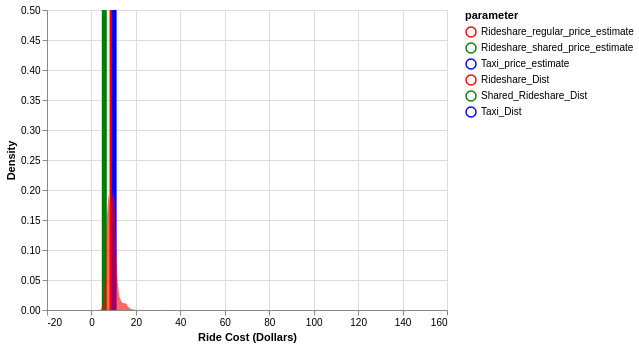

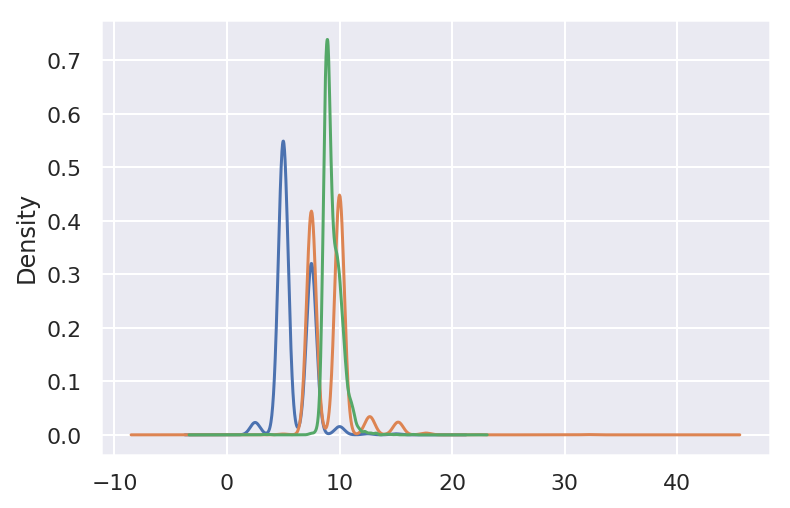

In [87]:
show_viz(results)

### Airport Trip

Rideshare_regular_price_estimate    39.68
Rideshare_shared_price_estimate     28.12
Taxi_price_estimate                 52.75
Name: 0, dtype: float64
121.65


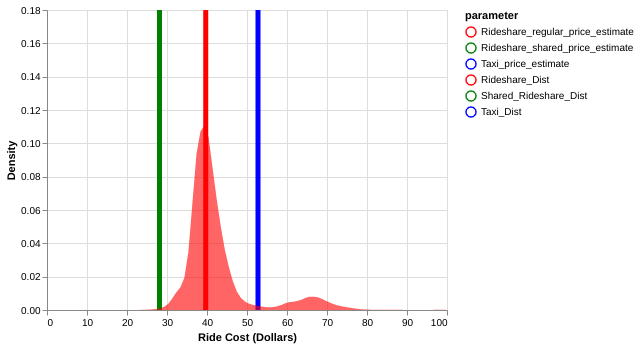

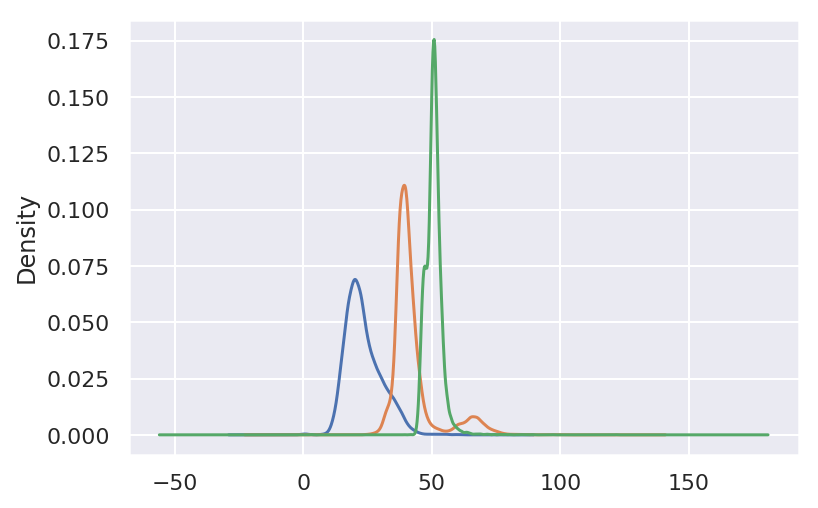

In [58]:
USER_PARAMS = {"pickup": "chicago ohare airport",
               "dropoff": "the bean chicago",
               "forecast_hrs":1}

results = run_Fair_Fare(USER_PARAMS)

pd.set_option("display.precision", 2)
print(pd.DataFrame(results[5]).iloc[0])

show_viz(results)

### Audience Participation

Rideshare_regular_price_estimate    43.54
Rideshare_shared_price_estimate     31.22
Taxi_price_estimate                 62.64
Name: 0, dtype: float64
230.5


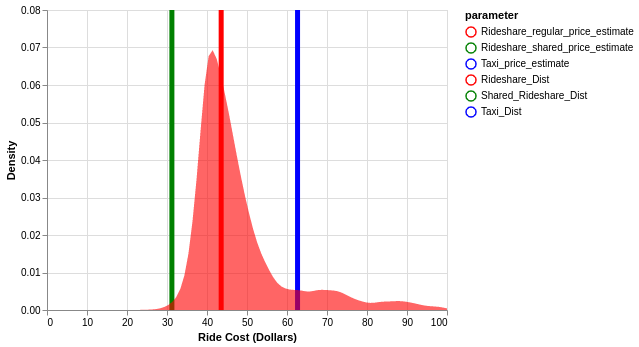

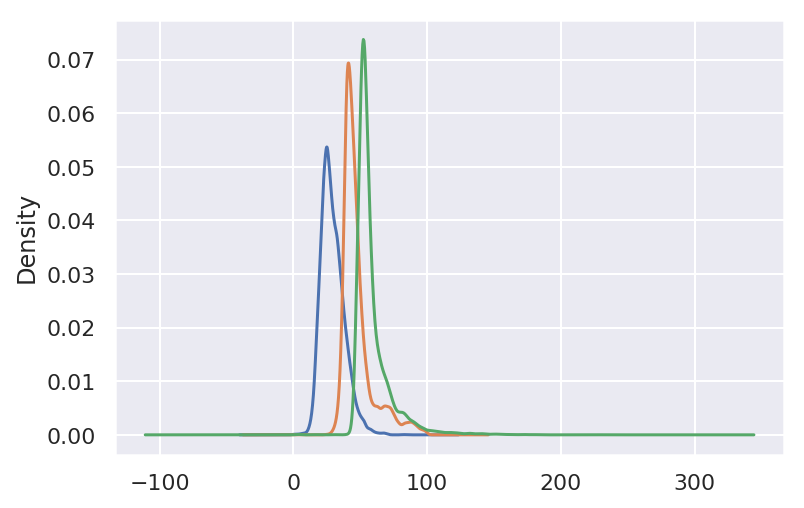

In [59]:
USER_PARAMS = {"pickup": "chicago ohare airport",
               "dropoff": "the shedd aquarium chicago",
               "forecast_hrs":1}

results = run_Fair_Fare(USER_PARAMS)

pd.set_option("display.precision", 2)
print(pd.DataFrame(results[5]).iloc[0])

show_viz(results)